# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/projects/nlp/NER/

/content/drive/My Drive/projects/nlp/NER


# Install and import libraries

In [ ]:
# Install hugging face library
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 2.0MB 5.5MB/s 
     |████████████████████████████████| 870kB 28.3MB/s 
     |████████████████████████████████| 3.3MB 29.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=11ab6b3391478fa22fb22147f5fc003bfc319a0a8827dddf41922aed0f7e5017
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=6dfef5355e878a619c0e56b986561cf09bc9c0daf7a5fa8cdfea0f524467f0aa
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

# Check GPU availability

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)

'Tesla K80'

# **Preprocessing data**

In [ ]:
# Reading data
data = []
readfile = open("train.txt", "r")
for line in readfile:
  if line == "\n":
    Type = "End of sentence"
  else:
    Type = line.strip().split("|")
  data.append(Type)

data = np.array(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
labels, line_labels, sentences, line_words = [], [], [], []
data_tags = []
for line in data:
  if line[1] != ' ':
    data_tags.append(line[1])
    if line != "End of sentence":
      line_labels.append(line[1])
      line_words.append(line[0])
    else:
      labels.append(line_labels)
      sentences.append(line_words)

      line_labels, line_words = [], []

In [ ]:
print(sentences[0],"\n",labels[0])

['مدیران', 'چهارمین', 'جشنواره', 'فیلم', 'و', 'عکس', 'فناوری', 'و', 'صنعتی', 'معرفی', 'شدند'] 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# Determine the list of tags
tag_values = list(set(data_tags))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag_values)

['B_LOC', 'B_TIM', 'B_ORG', 'B_PCT', 'n', 'I_TIM', 'I_PCT', 'B_DAT', 'I_MON', 'B_PER', 'I_DAT', 'O', 'B_MON', 'I_ORG', 'I_LOC', 'I_PER', 'PAD']


In [ ]:
# To use the BERT, you must use the BERT Tokenizer
# Persian BERT Tokenizer = HooshvareLab/bert-fa-base-uncased
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased', do_lower_case=False)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 64 # 64 or 128 or ...
bs = 32 # batch size

In [ ]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# **Build model**

In [ ]:
# Load Persian BERT Model
model = BertForTokenClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

In [ ]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)

In [ ]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# **Training**

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.19767633338450594


Epoch:  33%|███▎      | 1/3 [02:43<05:26, 163.10s/it]


Validation loss: 0.07094406361620013
Validation Accuracy: 0.9772807951721689


Average train loss: 0.04812228205135768


Epoch:  67%|██████▋   | 2/3 [05:25<02:43, 163.04s/it]


Validation loss: 0.06305505830096081
Validation Accuracy: 0.9810673293101408


Average train loss: 0.02719849103286994


Epoch: 100%|██████████| 3/3 [08:08<00:00, 162.71s/it]


Validation loss: 0.06545031836811596
Validation Accuracy: 0.980909557054392



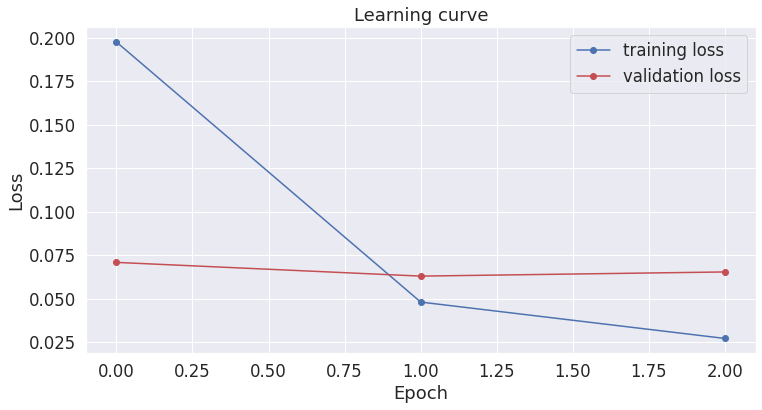

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [ ]:
# Reading data
data = []
readfile = open("test.txt", "r")
for line in readfile:
  if line == "\n":
    Type = "End of sentence"
  else:
    Type = line.strip().split("|")
  data.append(Type)

data = np.array(data)


labels, line_labels, sentences, line_words = [], [], [], []
data_tags = []
for line in data:
  if line[1] != ' ':
    data_tags.append(line[1])
    if line != "End of sentence":
      line_labels.append(line[1])
      line_words.append(line[0])
    else:
      labels.append(line_labels)
      sentences.append(line_words)

      line_labels, line_words = [], []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
accuracy_list = []
for i in range(len(sentences)):
  
  tokenized_sentence = tokenizer.encode(sentences[i])
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  with torch.no_grad():
      output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)

  new_labels = new_labels[1:-2]
  accuracy_list.append(accuracy_score(new_labels, labels[i]))
  print("\nPredict labels: ",new_labels)
  print("Actual labels: ",labels[i])

print("\n------------------ Performance on test data -------------------")
print("\nTest Accuracy: ", statistics.mean(accuracy_list))


Predict labels:  ['O', 'O', 'B_LOC', 'O', 'O', 'B_LOC', 'O', 'O', 'B_PER', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'O', 'O', 'B_LOC', 'O', 'O', 'O', 'O', 'B_LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'O']
Actual labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Predict labels:  ['O', 'O', 'B_PER', 'I_PER', 'B_DAT', 'I_DAT', 'O', 'O', 'O', 'O', 'B_PER', 'I_PER', 'O', 'O', 'O', 'O', 'B_LOC', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Predict labels:  ['O', 'O', 'O', 'O',